In [1]:
# PyTorch and model training
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CyclicLR
from torchmetrics import Accuracy
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torchinfo import summary
from tqdm.notebook import tqdm
import numpy as np
import random

# TensorBoard
from torch.utils.tensorboard import SummaryWriter
import subprocess
import webbrowser
from datetime import datetime
import time

# File I/O
import os
from PIL import Image
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Stanford40 Frames Model

## Define constants and set seed

In [2]:
# Training and evaluation
BATCH_SIZE = 32
LEARNING_RATE = 0.01
LEARNING_RATE_ADAPT_STEP = 5
LEARNING_RATE_ADAPT_GAMMA = 0.5
LEARNING_RATE_ADAPT_MIN = LEARNING_RATE / 10  # for cyclical learning rate schedule only
LEARNING_RATE_ADAPT_MAX = LEARNING_RATE  # for cyclical learning rate schedule only
EPOCHS = 50
DROPOUT_PROBABILITY = 0.2
IMAGE_SIZE = (224, 224)
DEVICE = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Device: {DEVICE}")

# TensorBoard
TENSORBOARD_TRACKING = False
TENSORBOARD_NOT_OPEN = TENSORBOARD_TRACKING

# Seed
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

Device: cuda


## Prepare dataset

### Load train, validation, and test splits

In [3]:
def input_list_from_file(file_path):
    list = []
    with open(file_path, "r") as f:
        for item in f:
            list.append(item.strip())
    return list

In [4]:
# Input training and validation set (oversampled splits for equal classes in training)
train_val_files = input_list_from_file(os.path.join("Stanford40", "train_val_files_osamp.txt"))
train_val_labels = input_list_from_file(os.path.join("Stanford40", "train_val_labels_osamp.txt"))
train_files = input_list_from_file(os.path.join("Stanford40", "train_files_osamp.txt"))
train_labels = input_list_from_file(os.path.join("Stanford40", "train_labels_osamp.txt"))
val_files = input_list_from_file(os.path.join("Stanford40", "val_files_osamp.txt"))
val_labels = input_list_from_file(os.path.join("Stanford40", "val_labels_osamp.txt"))
# Input test set
test_files = input_list_from_file(os.path.join("Stanford40", "test_files.txt"))
test_labels = input_list_from_file(os.path.join("Stanford40", "test_labels.txt"))

# Map action categories to 0-11 labels
action_categories = ["applauding", "climbing", "drinking", "jumping", "pouring_liquid", "riding_a_bike", "riding_a_horse",
        "running", "shooting_an_arrow", "smoking", "throwing_frisby", "waving_hands"]
action_categories_map = {action: idx for idx, action in enumerate(action_categories)}
train_val_labels_mapped = [action_categories_map[label] for label in train_val_labels]
train_labels_mapped = [action_categories_map[label] for label in train_labels]
val_labels_mapped = [action_categories_map[label] for label in val_labels]
test_labels_mapped = [action_categories_map[label] for label in test_labels]

### Define data transformations

In [5]:
class SquarePad:
    def __call__(self, img):
        max_size = max(img.size)

        pad_left = (max_size - img.size[0]) // 2
        pad_top = (max_size - img.size[1]) // 2

        # Account for odd sizes
        pad_right = max_size - (img.size[0] + pad_left)
        pad_bottom = max_size - (img.size[1] + pad_top)

        return transforms.functional.pad(img, (pad_left, pad_top, pad_right, pad_bottom), 0, "constant")

In [6]:
train_val_transforms = transforms.Compose([
    SquarePad(),
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.3),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomAutocontrast(p=0.1),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.1),
    transforms.ToTensor(),
    # ImageNet normalization
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    SquarePad(),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    # ImageNet normalization
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Define custom dataset and create data loaders

In [7]:
class Stanford40Dataset(Dataset):
    def __init__(self, files, labels, images_path, transform=None):
        self.files = files
        self.labels = labels
        self.images_path = images_path
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        image_name = self.files[index]
        image_path = os.path.join(self.images_path, image_name)
        img = Image.open(image_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        label = self.labels[index]

        return img, label

In [8]:
images_path = os.path.join("Stanford40", "JPEGImages")
train_val_dataset = Stanford40Dataset(train_val_files, train_val_labels_mapped, images_path, transform=train_val_transforms)
train_dataset = Stanford40Dataset(train_files, train_labels_mapped, images_path, transform=train_val_transforms)
val_dataset = Stanford40Dataset(val_files, val_labels_mapped, images_path, transform=train_val_transforms)
test_dataset = Stanford40Dataset(test_files, test_labels_mapped, images_path, transform=test_transforms)

train_val_loader = DataLoader(train_val_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Define, train, and evaluate model with pre-trained weights

### Import ResNet18 as model architecture, add dropout after global average pooling, modify output to number of action classes, and show summary

In [9]:
spatial_stanford40 = models.resnet18(weights="DEFAULT")

spatial_stanford40.fc = nn.Sequential(
    nn.Dropout(DROPOUT_PROBABILITY),
    nn.Linear(spatial_stanford40.fc.in_features, len(action_categories))
)

summary(model=spatial_stanford40, input_size=(BATCH_SIZE, 3, *IMAGE_SIZE),
        col_width=20, col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 12]             --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     36,864               True
│    │    └─BatchN

### Train and validate model

In [10]:
def train_model_multiclass(model, num_classes, train_loader, validation_loader=None, device="cpu", epochs=15, lr=0.001,
                           adapt_lr="step", adapt_lr_step=5, adapt_lr_gamma=0.5, adapt_lr_max=-1,
                           tensorboard_tracking=False, experiment_name="Multiclass Classification", model_name=None):
    """
    Trains a model for multiclass classification.

    :param model: model
    :param num_classes: number of classes
    :param train_loader: training data loader
    :param validation_loader: validation data loader, if None then no validation
    :param device: device choice
    :param epochs: number of epochs
    :param lr: learning rate
    :param adapt_lr: "step" to adapt learning rate after certain amount of steps,
                     "cyclical" to create cyclical learning rate schedule,
                     otherwise static learning rate
    :param adapt_lr_step: number of epochs to change learning rate after if adapt_lr is "step" or "cyclical"
    :param adapt_lr_gamma: learning rate adaptation gamma if adapt_lr is "step" or "cyclical"
    :param adapt_lr_max: max learning rate in cycle if adapt_lr is "cyclical" (base learning rate is set to lr),
                         if -1 then set to 10 times the base learning rate
    :param tensorboard_tracking: tracks training with TensorBoard if True
    :param experiment_name: experiment name for Tensorboard for when tensorboard_tracking is True
    :param model_name: model name for Tensorboard for when tensorboard_tracking is True,
                       if None then uses class name of model

    :return: returns model at best epoch, dictionary of training and validation results up to best epoch,
             and learning rates up to best epoch
    """
    global TENSORBOARD_NOT_OPEN

    # Experiment tracking setup using TensorBoard
    if tensorboard_tracking:
        # Initialize a TensorBoard writer for logging
        timestamp = datetime.now().strftime("%Y-%m-%d")
        if model_name is None:
            model_name = model.__class__.__name__
        os.makedirs("runs", exist_ok=True)
        writer = SummaryWriter(os.path.join("runs", timestamp, experiment_name, model_name))

    # Define Loss Function
    loss_fn = nn.CrossEntropyLoss()
    # Define Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    if adapt_lr == "cyclical":
        if adapt_lr_max == -1:
            adapt_lr_max = 10 * lr
        scheduler = CyclicLR(optimizer, step_size_up=adapt_lr_step, base_lr=lr, max_lr=adapt_lr_max,
                             scale_fn=lambda x: adapt_lr_gamma ** (x - 1), scale_mode="cycle", cycle_momentum=False)
    else:
        scheduler = StepLR(optimizer, step_size=adapt_lr_step, gamma=adapt_lr_gamma)
    # Define output accuracy function
    accuracy = Accuracy(task="multiclass", num_classes=num_classes)

    # Move accuracy and model to the appropriate device
    accuracy = accuracy.to(device)
    model = model.to(device)

    history = {"train_loss":[], "val_loss":[], "train_acc": [], "val_acc": []}

    learning_rates = []

    best_val_acc = 0.0
    best_epoch = 0
    best_model_state = None

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = 0.0, 0.0

        # Iterating over batches of training data
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            # Set model to training mode
            model.train()

            # Forward pass to compute predictions
            y_pred = model(X)

            # Calculate the current batch loss and accuracy and aggregate
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()
            train_acc += accuracy(y_pred, y).item()

            # Zero out gradients
            optimizer.zero_grad()

            # Backpropagate the loss
            loss.backward()

            # Update model parameters
            optimizer.step()

        # Average training loss and accuracy over all batches
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        # Keep history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        val_loss, val_acc = 0.0, 0.0
        # If running validation
        if validation_loader is not None:
            # Set model to evaluation mode
            model.eval()
            # Context manager for inference without gradient tracking
            with torch.inference_mode():
                # Iterating over batches of validation data
                for X, y in validation_loader:
                    X, y = X.to(device), y.to(device)

                    # Forward pass to compute predictions
                    y_pred = model(X)

                    # Calculate the current batch loss and accuracy and aggregate
                    val_loss += loss_fn(y_pred, y).item()
                    val_acc += accuracy(y_pred, y).item()

            # Average validation loss and accuracy over all batches
            val_loss /= len(validation_loader)
            val_acc /= len(validation_loader)
            # Keep history
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)

            # Check if the validation accuracy improved
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                # Save the best model state
                best_epoch = epoch
                best_model_state = model.state_dict()
        else:
            # Keep values at 0 if not running validation
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)

        if tensorboard_tracking:
            # Log training and validation loss and accuracy to TensorBoard
            writer.add_scalars(main_tag="Validation Accuracy", tag_scalar_dict={"/acc": val_acc}, global_step=epoch)
            writer.add_scalars(main_tag="Validation Loss", tag_scalar_dict={"/loss": val_loss}, global_step=epoch)
            writer.add_scalars(main_tag="Train Accuracy", tag_scalar_dict={"/acc": train_acc}, global_step=epoch)
            writer.add_scalars(main_tag="Train Loss", tag_scalar_dict={"/loss": train_loss}, global_step=epoch)

            if TENSORBOARD_NOT_OPEN:
                TENSORBOARD_NOT_OPEN = False
                subprocess.Popen(f"tensorboard --logdir=runs --port={6007}", shell=True)
                # Open a web browser tab, the time delay allows TensorBoard to start up
                time.sleep(5)
                webbrowser.open_new_tab("http://localhost:6007")

        print(f"Epoch: {epoch}| Train loss: {train_loss: .5f}| Train acc: {train_acc: .5f}| Val loss: {val_loss: .5f}| Val acc: {val_acc: .5f}")

        # Get epoch learning rate
        learning_rates.append(scheduler.get_last_lr())
        # Step scheduler for learning rate adaptation
        if adapt_lr == "step" or adapt_lr == "cyclical":
            scheduler.step()

    # Revert model to best state after training
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        # Cut the history up to the best epoch
        history["train_loss"] = history["train_loss"][:best_epoch + 1]
        history["train_acc"] = history["train_acc"][:best_epoch + 1]
        history["val_loss"] = history["val_loss"][:best_epoch + 1]
        history["val_acc"] = history["val_acc"][:best_epoch + 1]
        learning_rates = learning_rates[:best_epoch + 1]

    if tensorboard_tracking:
        writer.close()

    return model, history, learning_rates

In [11]:
spatial_stanford40, history_spatial_stanford40, lrs_spatial_stanford40 = train_model_multiclass(
    spatial_stanford40, len(action_categories), train_loader, val_loader, DEVICE,
    EPOCHS, LEARNING_RATE, "step", LEARNING_RATE_ADAPT_STEP, LEARNING_RATE_ADAPT_GAMMA,
    tensorboard_tracking=TENSORBOARD_TRACKING, experiment_name="spatial_stanford40", model_name="spatial_stanford40"
)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0| Train loss:  3.09055| Train acc:  0.08292| Val loss:  4.95999| Val acc:  0.07955
Epoch: 1| Train loss:  2.66781| Train acc:  0.08403| Val loss:  2.81950| Val acc:  0.10227
Epoch: 2| Train loss:  2.50941| Train acc:  0.09917| Val loss:  2.53806| Val acc:  0.09375
Epoch: 3| Train loss:  2.46914| Train acc:  0.11125| Val loss:  2.75533| Val acc:  0.14489
Epoch: 4| Train loss:  2.42799| Train acc:  0.12979| Val loss:  2.47473| Val acc:  0.09943
Epoch: 5| Train loss:  2.35751| Train acc:  0.15354| Val loss:  2.97343| Val acc:  0.09091
Epoch: 6| Train loss:  2.32981| Train acc:  0.16285| Val loss:  3.32531| Val acc:  0.13352
Epoch: 7| Train loss:  2.27929| Train acc:  0.17535| Val loss:  2.75893| Val acc:  0.13352
Epoch: 8| Train loss:  2.22863| Train acc:  0.18104| Val loss:  2.39957| Val acc:  0.14773
Epoch: 9| Train loss:  2.20058| Train acc:  0.21396| Val loss:  2.68568| Val acc:  0.10227
Epoch: 10| Train loss:  2.13300| Train acc:  0.22785| Val loss:  2.20800| Val acc:  0.2301

### Plot accuracy and loss for training and validation

In [12]:
def plot_train_val_metrics(history, model_name="Model", file_name="results_model.png"):
    """
    Plots accuracy and loss for training and validation sets and outputs to file.

    :param history: dictionary of training and validation results
    :param model_name: model name for plot title
    :param file_name: output file name
    """
    plt.figure(figsize=(10, 4))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Training Loss", color="black")
    plt.plot(history["val_loss"], label="Validation Loss", color="red")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Training Accuracy", color="black")
    plt.plot(history["val_acc"], label="Validation Accuracy", color="red")
    plt.title("Training & Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Add a main title for the whole figure
    plt.suptitle(f"Training and Validation Metrics for {model_name}")

    # Adjust layout and show plot
    plt.tight_layout()

    # Save plot to file
    os.makedirs("plots", exist_ok=True)
    plt.savefig(os.path.join("plots", file_name), bbox_inches="tight", dpi=300)

    plt.show()

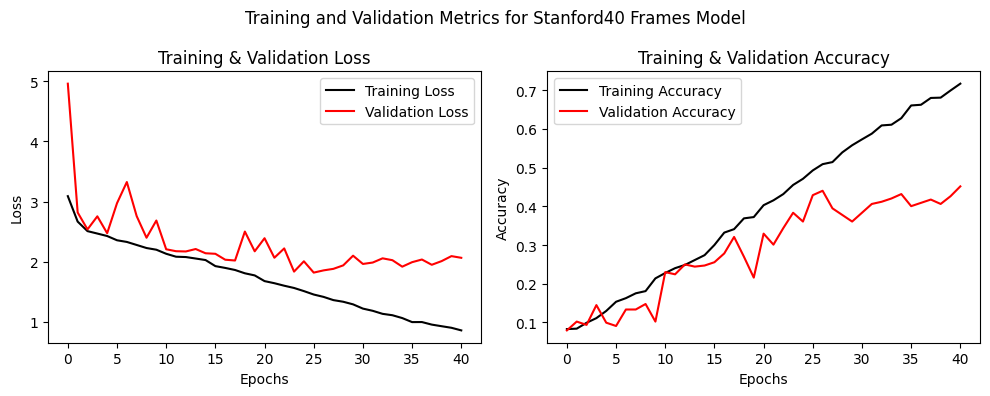

In [13]:
plot_train_val_metrics(history_spatial_stanford40, "Stanford40 Frames Model", "results_spatial_stanford40.png")

### Plot learning rate during training

In [14]:
def plot_lr(lr_per_epoch, model_name="Model", file_name="lrs_model.png"):
    """
    Plots learning rates for every epoch and outputs to file.

    :param lr_per_epoch: learning rate for every epoch
    :param model_name: model name for plot title
    :param file_name: output file name
    """
    # Plot learning rate
    plt.figure(figsize=(6, 4))
    plt.plot(lr_per_epoch)
    plt.xlabel("Epochs")
    plt.ylabel("Learning Rate")
    plt.title(f"Adaptive Learning Rate During Training for {model_name}")

    # Save plot to file
    os.makedirs("plots", exist_ok=True)
    plt.savefig(os.path.join("plots", file_name), bbox_inches="tight", dpi=300)

    plt.show()

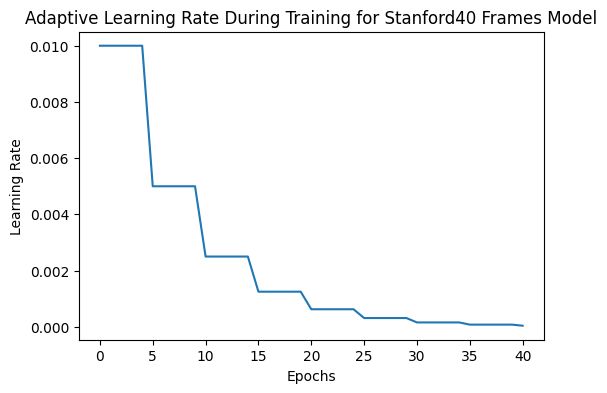

In [15]:
plot_lr(lrs_spatial_stanford40, "Stanford40 Frames Model", "lrs_spatial_stanford40.png")

### Export model

In [16]:
def export_model(model, model_name="model"):
    """
    Outputs model to file.

    :param model: model
    :param model_name: model name for output file name
    """
    # Export model to TorchScript
    model_scripted = torch.jit.script(model)

    # Save model
    os.makedirs("models", exist_ok=True)
    model_scripted.save(os.path.join("models", model_name + ".pt"))

In [17]:
export_model(spatial_stanford40, "spatial_stanford40")

### Evalutate model on test set

In [18]:
def test_model_multiclass(model, num_classes, test_loader, device="cpu"):
    """
    Tests a trained multiclass classification model on test data.

    :param model: model
    :param num_classes: number of classes
    :param test_loader: test data loader
    :param device: device choice
    :return: returns test loss, test accuracy, predicted labels, and actual labels
    """
    # Define Loss Function
    loss_fn = nn.CrossEntropyLoss()
    # Define output accuracy function
    accuracy = Accuracy(task="multiclass", num_classes=num_classes)

    # Move accuracy and model to the appropriate device
    accuracy = accuracy.to(device)
    model = model.to(device)

    test_loss, test_acc = 0, 0
    y_preds = []
    y_labels = []

    # Set model to evaluation mode
    model.eval()
    with torch.inference_mode():
        # Iterating over batches of test data
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)

            # Forward pass to compute predictions
            y_pred = model(X)

            # Calculate the current batch loss and accuracy and aggregate
            test_loss += loss_fn(y_pred, y).item()
            test_acc += accuracy(y_pred, y).item()

            # Store predictions and labels
            y_preds.extend(y_pred.argmax(dim=1).cpu().numpy())
            y_labels.extend(y.cpu().numpy())

        # Average test loss and accuracy over all batches
        test_loss /= len(test_loader)
        test_acc /= len(test_loader)

    print(f"Test loss: {test_loss: .5f}| Test acc: {test_acc: .5f}")

    return test_loss, test_acc, y_preds, y_labels

In [19]:
test_loss_spatial_stanford40, test_acc_spatial_stanford40, y_preds_spatial_stanford40, y_labels_spatial_stanford40 \
    = test_model_multiclass(spatial_stanford40, len(action_categories), test_loader, DEVICE)

Test loss:  1.92087| Test acc:  0.46875


### Plot confusion matrix

In [20]:
def plot_confusion_matrix(preds, labels, labels_map, model_name="Model", file_name="cm_model.png"):
    """
    Plots confusion matrix of predicted labels and actual labels and outputs to file.

    :param preds: predicted labels
    :param labels: actual labels
    :param labels_map: dictionary of labels mapped to numeric model labels
    :param model_name: model name for plot title
    :param file_name: output file name
    """
    # Extract label names based on mapping
    label_names = [label for label, idx in labels_map.items()]

    # Compute confusion matrix
    cm = confusion_matrix(labels, preds)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("True labels")
    plt.ylabel("Predicted labels")
    plt.title(f"Confusion Matrix for {model_name}")

    # Save plot to file
    os.makedirs("plots", exist_ok=True)
    plt.savefig(os.path.join("plots", file_name), bbox_inches="tight", dpi=300)

    plt.show()

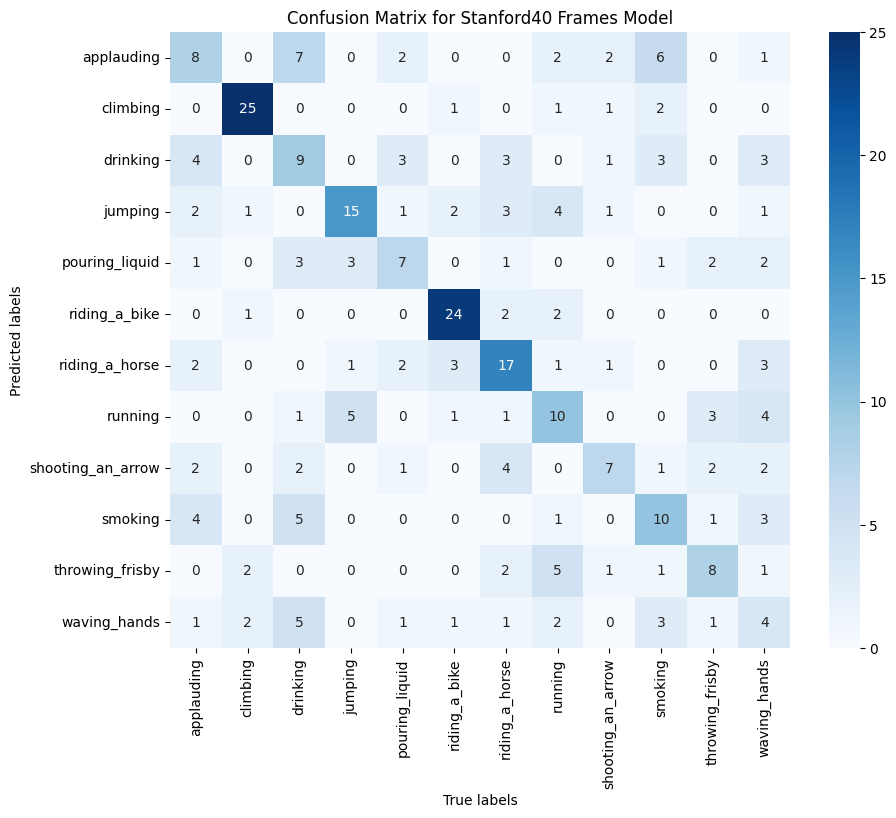

In [21]:
plot_confusion_matrix(y_preds_spatial_stanford40, y_labels_spatial_stanford40, action_categories_map,
                      "Stanford40 Frames Model", "cm_spatial_stanford40.png")

## Train a new model using a cyclical learning rate schedule and evaluate

### Redefine model

In [22]:
spatial_stanford40_cyc = models.resnet18(weights="DEFAULT")

spatial_stanford40_cyc.fc = nn.Sequential(
    nn.Dropout(DROPOUT_PROBABILITY),
    nn.Linear(spatial_stanford40_cyc.fc.in_features, len(action_categories))
)

### Train and validate model

In [23]:
spatial_stanford40_cyc, history_spatial_stanford40_cyc, lrs_spatial_stanford40_cyc = train_model_multiclass(
    spatial_stanford40_cyc, len(action_categories), train_loader, val_loader, DEVICE,
    EPOCHS, LEARNING_RATE_ADAPT_MIN, "cyclical", LEARNING_RATE_ADAPT_STEP, LEARNING_RATE_ADAPT_GAMMA, LEARNING_RATE_ADAPT_MAX,
    tensorboard_tracking=TENSORBOARD_TRACKING, experiment_name="spatial_stanford40", model_name="spatial_stanford40_cyclical"
)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0| Train loss:  1.56194| Train acc:  0.45833| Val loss:  1.56336| Val acc:  0.46591
Epoch: 1| Train loss:  1.91418| Train acc:  0.35958| Val loss:  1.87036| Val acc:  0.40057
Epoch: 2| Train loss:  1.92972| Train acc:  0.34937| Val loss:  2.82594| Val acc:  0.22443
Epoch: 3| Train loss:  1.83929| Train acc:  0.38632| Val loss:  2.49509| Val acc:  0.26705
Epoch: 4| Train loss:  1.88299| Train acc:  0.37278| Val loss:  2.42464| Val acc:  0.33523
Epoch: 5| Train loss:  1.69691| Train acc:  0.42736| Val loss:  2.27444| Val acc:  0.33807
Epoch: 6| Train loss:  1.43548| Train acc:  0.51958| Val loss:  1.83972| Val acc:  0.44318
Epoch: 7| Train loss:  1.20931| Train acc:  0.57792| Val loss:  1.66921| Val acc:  0.46307
Epoch: 8| Train loss:  1.03371| Train acc:  0.64736| Val loss:  1.39145| Val acc:  0.54261
Epoch: 9| Train loss:  0.82184| Train acc:  0.71910| Val loss:  1.37508| Val acc:  0.53693
Epoch: 10| Train loss:  0.65581| Train acc:  0.77194| Val loss:  1.14170| Val acc:  0.6392

### Plot accuracy and loss for training and validation

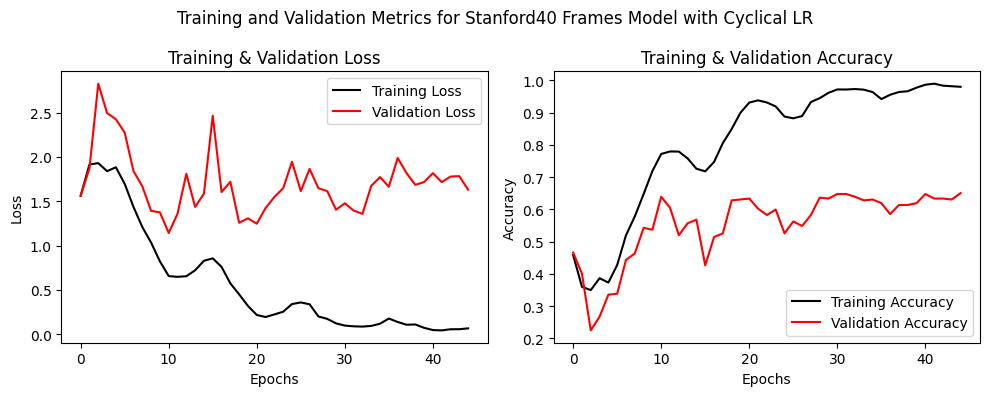

In [24]:
plot_train_val_metrics(history_spatial_stanford40_cyc,
                       "Stanford40 Frames Model with Cyclical LR", "results_spatial_stanford40_cyclical.png")

### Plot cyclical learning rate during training

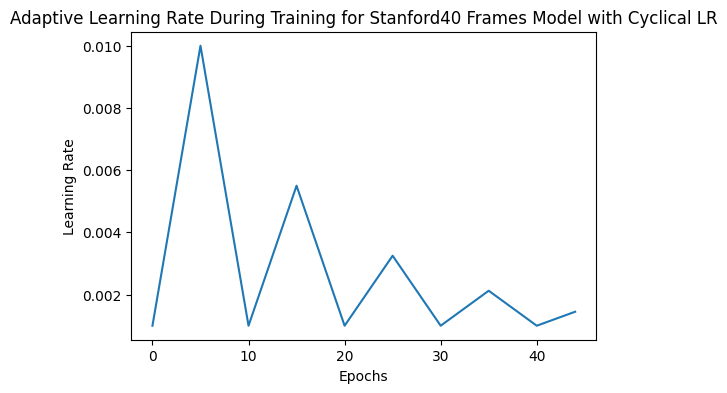

In [25]:
plot_lr(lrs_spatial_stanford40_cyc, "Stanford40 Frames Model with Cyclical LR", "lrs_spatial_stanford40_cyclical.png")

### Export model

In [26]:
export_model(spatial_stanford40_cyc, "spatial_stanford40_cyclical")

### Evalutate model on test set

In [27]:
test_loss_spatial_stanford40_cyc, test_acc_spatial_stanford40_cyc, y_preds_spatial_stanford40_cyc, y_labels_spatial_stanford40_cyc \
    = test_model_multiclass(spatial_stanford40_cyc, len(action_categories), test_loader, DEVICE)

Test loss:  1.70559| Test acc:  0.66250


### Plot confusion matrix

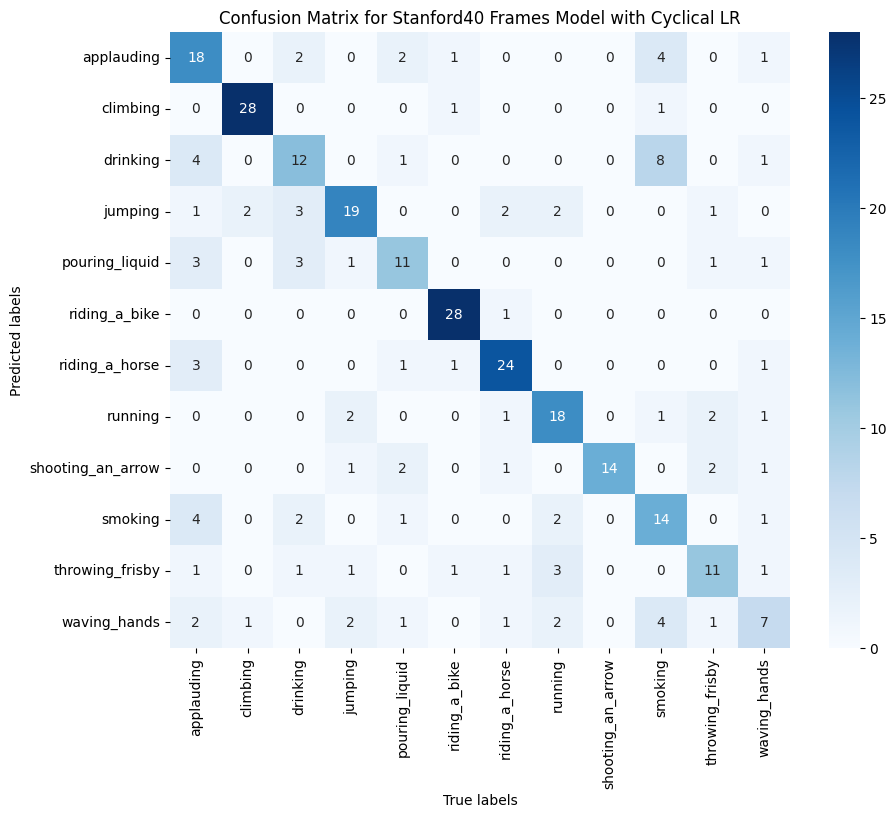

In [28]:
plot_confusion_matrix(y_preds_spatial_stanford40_cyc, y_labels_spatial_stanford40_cyc, action_categories_map,
                      "Stanford40 Frames Model with Cyclical LR", "cm_spatial_stanford40_cyclical.png")

## Save all model results

In [29]:
def export_model_metrics(model_metrics, file_name="metrics_model.csv"):
    """
    Outputs training, validation, and test results for multiple models to file.

    :param model_metrics: dictionary of dictionaries for every model with best epoch training and validation results
                          and final test results
    :param file_name: output file name
    """
    # Convert metrics to dataframe
    model_metrics_df = pd.DataFrame.from_dict(model_metrics, orient="index")
    print(model_metrics_df)

    # Save dataframe
    os.makedirs("results", exist_ok=True)
    model_metrics_df.to_csv(os.path.join("results", file_name))

In [30]:
model_metrics = {
    "spatial_model_stanford40": {
        "train_loss": history_spatial_stanford40["train_loss"][-1],
        "val_loss": history_spatial_stanford40["val_loss"][-1],
        "train_acc": history_spatial_stanford40["train_acc"][-1],
        "val_acc": history_spatial_stanford40["val_acc"][-1],
        "test_loss": test_loss_spatial_stanford40,
        "test_acc": test_acc_spatial_stanford40
    },
    "spatial_model_stanford40_cyclical": {
        "train_loss": history_spatial_stanford40_cyc["train_loss"][-1],
        "val_loss": history_spatial_stanford40_cyc["val_loss"][-1],
        "train_acc": history_spatial_stanford40_cyc["train_acc"][-1],
        "val_acc": history_spatial_stanford40_cyc["val_acc"][-1],
        "test_loss": test_loss_spatial_stanford40_cyc,
        "test_acc": test_acc_spatial_stanford40_cyc
    }
}

export_model_metrics(model_metrics, "metrics_spatial_stanford40.csv")

                                   train_loss  val_loss  train_acc   val_acc  \
spatial_model_stanford40             0.859837  2.066059   0.717083  0.451705   
spatial_model_stanford40_cyclical    0.066121  1.630154   0.980347  0.650568   

                                   test_loss  test_acc  
spatial_model_stanford40            1.920872   0.46875  
spatial_model_stanford40_cyclical   1.705593   0.66250  
